In [1]:
%pylab
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(1,'../src')
sys.path.insert(1,'../')

matplotlib.rcParams['savefig.dpi'] = 1.5 * matplotlib.rcParams['savefig.dpi']
from __future__ import print_function
import timeit
from ellipsoid import *

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


### Mixture of two Gaussians

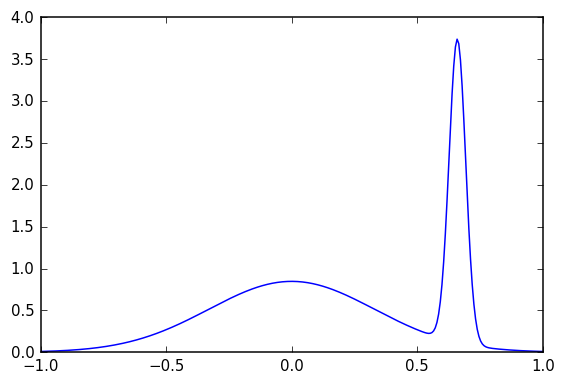

In [2]:
#distribution = mixture_distribution([normal_distribution(-.45, .15), normal_distribution(.3, .2)], [.65, .35])
#distribution = mixture_distribution([normal_distribution(0.0, 1.0), normal_distribution(0.0, 1.0)], [1.0, 0.0])
distribution = mixture_distribution([normal_distribution(0, 0.33), normal_distribution(.66, .033)], [.7, .3])
fig = plot_distribution(distribution, (-1, 1))

### We draw samples

In [3]:
n = 100000
samples = sorted(distribution.draw_samples(n))

smin = np.min(samples) - 1e-3
smax = np.max(samples) + 1e-3
print('n = {}  min = {}  max = {}'.format(n, np.min(samples), np.max(samples)))

n = 100000  min = -1.40908091516  max = 1.36886376707


The plot only shows a subset of the samples.

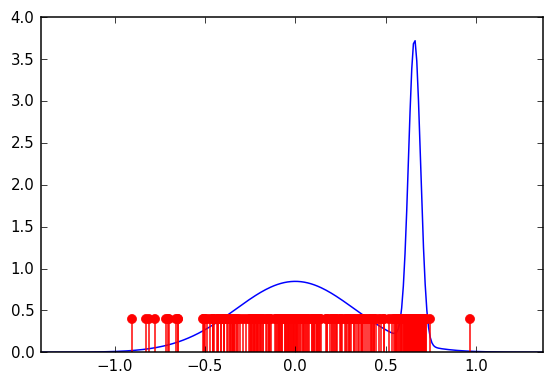

In [4]:
fig = plot_distribution_with_samples(distribution, np.random.choice(samples, 300), (smin, smax))

### Let's run our algorithm
We want 4 or 5 pieces of degree 5 and start with 20 intervals of equal empirical mass.

In [5]:
%%time
t = 4
d = 9
U = d * d * (math.sqrt(2) + 1.0)**d
eps = math.sqrt(t * d / float(n))
print('eps estimate = {}'.format(eps))
akproj_gap_tolerance = eps * eps * 0.5
print('akproj_gap_tolerance = {}'.format(akproj_gap_tolerance))
#num_pieces = int(math.ceil(t / eps))
num_initial_pieces = 200
print('Upper bound = {}  Num initial pieces = {}'.format(U, num_initial_pieces))
cvxopt.solvers.options['show_progress'] = False

start = timeit.default_timer()
%prun res = pp_learning(t, d, num_initial_pieces, (smin, smax), samples, verbose=1, akproj_num_iter=200, akproj_upper_bound=U, akproj_gap_tolerance=akproj_gap_tolerance)
stop = timeit.default_timer()

print("timeit time: {} seconds".format(float(stop - start)))

eps estimate = 0.018973665961
akproj_gap_tolerance = 0.00018
Upper bound = 225666.029074  Num initial pieces = 200
Computing initial pieces
num oracle = 31  num_newton = 331

num oracle = 16  num_newton = 198

num oracle = 13  num_newton = 155

num oracle = 10  num_newton = 126

num oracle = 10  num_newton = 204

num oracle = 10  num_newton = 160

num oracle = 9  num_newton = 112

num oracle = 7  num_newton = 87

num oracle = 8  num_newton = 109

num oracle = 8  num_newton = 224

num oracle = 7  num_newton = 188

num oracle = 8  num_newton = 125

num oracle = 8  num_newton = 119

num oracle = 7  num_newton = 107

num oracle = 8  num_newton = 156

num oracle = 8  num_newton = 158

num oracle = 8  num_newton = 89

num oracle = 8  num_newton = 177

num oracle = 9  num_newton = 164

num oracle = 9  num_newton = 200

num oracle = 8  num_newton = 169

num oracle = 8  num_newton = 160

num oracle = 8  num_newton = 88

num oracle = 8  num_newton = 109

num oracle = 7  num_newton = 162

num ora

The running time is quite long, but there are better cutting plane methods to make things faster. Also, only part of the code is in C++ at the moment.

### Result

Error $\varepsilon$ in $L_1$-distance:

In [6]:
l1_err = compute_l1_quad(distribution.get_pdf(), get_ppoly_pdf(res), (smin, smax))
print('\nL1 error: {}'.format(l1_err))


L1 error: 0.0172656689327


How many samples do we need to get this accuracy according to our prediction? $\frac{d t}{\varepsilon^2}$ is

In [7]:
d * t / l1_err**2

120763.49754874174

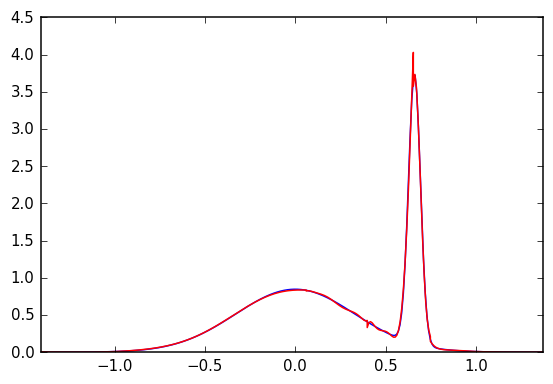

In [8]:
fig = plot_distribution(distribution, (smin, smax))
fig = plot_poly([res], (smin, smax), fig, ['red'])

This is the description of our piecewise-polynomial hypothesis.

In [21]:
sizes = [ppart.right - ppart.left for ppart in res]
weights = [ppart.right_sample_index - ppart.left_sample_index for ppart in res]
print('sizes: {}'.format(sizes))
print('weights: {}'.format(weights))
res

sizes: [1.44429431386195, 0.37545402667877198, 0.074538214936877401, 0.077679476466024355, 0.60933642862067217]
weights: [52000, 16000, 18000, 13000, 1000]


[HypothesisPiece(left=-1.2270069808563353, right=0.21728733300561459, left_sample_index=0, right_sample_index=52000, hypothesis=array([ -1.41932510e+01,  -6.46807364e+01,  -1.10452154e+02,
        -7.78703374e+01,  -3.91869888e+00,   2.08816775e+01,
         3.82741134e+00,  -4.00535167e+00,  -1.00279757e-01,
         8.45467688e-01])),
 HypothesisPiece(left=0.21728733300561459, right=0.59274135968438657, left_sample_index=52000, right_sample_index=68000, hypothesis=array([  6.77168497e+04,  -9.27006186e+04,  -1.20536787e+03,
         6.18047615e+04,  -3.46507591e+04,   2.03065124e+03,
         4.08178514e+03,  -1.50233547e+03,   2.09260532e+02,
        -9.50742604e+00])),
 HypothesisPiece(left=0.59274135968438657, right=0.66727957462126397, left_sample_index=68000, right_sample_index=86000, hypothesis=array([-17214.88038972,  -7327.34214227,   3096.54259299,  10500.26195879,
        10979.74943375,   2769.10936281,  -9298.02278637, -10533.85077634,
        11540.91694025,  -2615.86277

### Some attempts at post-processing - ignore

In [55]:
res2 = pp_patch(res, eps * 3.0, samples, remove_small_pieces=False)
sizes = [ppart.right - ppart.left for ppart in res2]
weights = [ppart.right_sample_index - ppart.left_sample_index for ppart in res2]
print('sizes: {}'.format(sizes))
print('weights: {}'.format(weights))
len(res2)

sizes: [1.4050140365777759, 0.082260941468279974, 0.23230787292449939, 0.12638644638517033, 0.040927823701714772, 0.015190738921220248, 0.029305074982509338, 0.62648179509358559, 0.023427730509540279]
weights: [49154, 5692, 10308, 5692, 12308, 5692, 7308, 3845, 1]


9

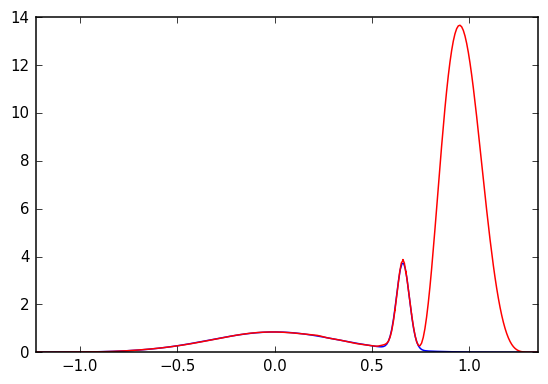

In [56]:
fig = plot_distribution(distribution, (smin, smax))
fig = plot_poly([res2], (smin, smax), fig, ['red'])

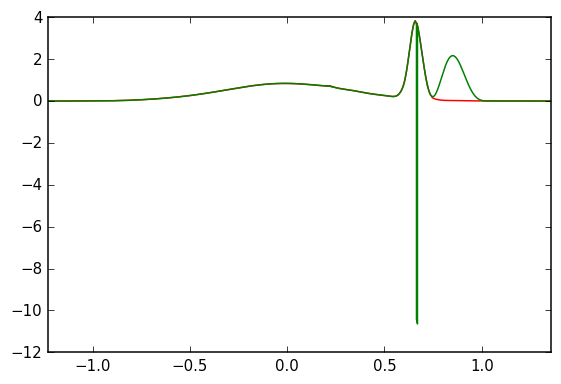

In [30]:
fig = plot_poly([res, res2], (smin, smax), colors=['red', 'green'])

In [13]:
l1_err_patched = compute_l1_quad(distribution.get_pdf(), get_ppoly_pdf(res2), (smin, smax))
print('\nPatched L1 error: {}'.format(l1_err_patched))


Patched L1 error: 0.069396063375


In [14]:
l1_err = compute_l1_quad(distribution.get_pdf(), get_ppoly_pdf(res), (smin, smax))
print('\nL1 error: {}'.format(l1_err))


L1 error: 0.024732464814


In [15]:
eps

0.018973665961010275

In [16]:
res2

[HypothesisPiece(left=-1.2270069808563353, right=-0.14335486260616062, left_sample_index=0, right_sample_index=23052, hypothesis=array([  4.18389526e+01,   2.17591348e+02,   4.31643056e+02,
         3.55578512e+02,  -2.04552275e+01,  -2.77727328e+02,
        -2.31669459e+02,  -8.86429640e+01,  -1.46702320e+01,
        -1.03223383e-01])),
 HypothesisPiece(left=-0.14335486260616062, right=-0.11892782159439076, left_sample_index=23052, right_sample_index=24948, hypothesis=array([  1.66107396e+11,  -4.70369912e+10,  -1.51507985e+11,
        -8.47645176e+10,  -2.41103791e+10,  -4.11672220e+09,
        -4.41216873e+08,  -2.92237906e+07,  -1.09787007e+06,
        -1.79466568e+04])),
 HypothesisPiece(left=-0.11892782159439076, right=0.12411223768147511, left_sample_index=24948, right_sample_index=45052, hypothesis=array([  7.29341727e+03,   9.31268483e+03,   1.30573673e+05,
        -2.77032426e+04,  -1.06391349e+04,   5.10720688e+02,
         1.59683408e+02,  -4.33521902e+00,  -4.83672118e-01,